## Background

In the [second half of the fastai Lesson 9 video](https://youtu.be/_7rMfsA24Ls?feature=shared&t=2772), Jeremy introduces the idea of a "magic API" that predicts the probability an image is a handwritten digit—where clearer images result in higher probabilities and noisier ones yield lower scores.


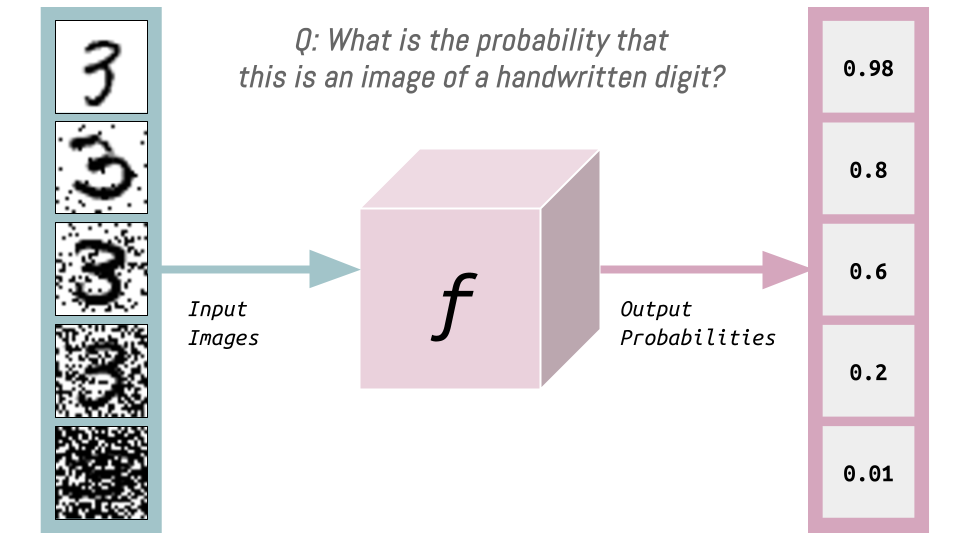

Inspired by this, I set out to build a neural network that predicts the probability an image is a handwritten digit. But I wanted to go a step further and bring abstract ideas into something tangible, so I designed a [HuggingFace Space](https://huggingface.co/spaces/vishalbakshi/isitadigit) where users can interactively explore how this probability shifts as they draw. The Space connects to an [inference endpoint](https://huggingface.co/spaces/vishalbakshi/isitadigit-inference/blob/main/app.py) hosting the model trained in this notebook. As you sketch on the canvas, the app dynamically sends the image to the endpoint, processes it through the model, and displays the predicted probability beneath the drawing.

The frontend for this project came together thanks to Claude-3.5 Sonnet, which generated most of the code. The initial proof-of-concept is available on [this Codepen](https://codepen.io/vishalbakshi/full/eYweKrN).

In [2]:
import matplotlib.pyplot as plt
from fastai.vision.all import *
import numpy as np
import requests
from io import BytesIO

## Generate Synthetic Data

The MNIST dataset contains images of handwritten digits. This alone is not sufficient for my training objective. I'll add varying levels of noise to the MNIST images---these will be my inputs. The outputs will be 1 minus the amount of noise (which I'll limit to the range `0.0` to `1.0`).

I want images where there is a lot of noise (black pixels) in addition to the black-pixel digit (on a white background). I also want images where some of the black pixels from the digit are removed. Both of these are approximately the kinds of images seen by my model in my **Is it a digit?** app.

### Loading Existing MNIST Data

I'll start by loading the original MNIST dataset and preparing the training and validation set tensors.

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

(#2) [Path('/root/.fastai/data/mnist_png/testing'),Path('/root/.fastai/data/mnist_png/training')]

In [4]:
training_files = [file for path in (path/'training').ls().sorted() for file in path.ls()]
validation_files = [file for path in (path/'testing').ls().sorted() for file in path.ls()]

In [5]:
len(training_files), len(validation_files)

(60000, 10000)

In [6]:
train_x = torch.stack([tensor(Image.open(o)) for o in training_files]).float()/255
train_x.shape

torch.Size([60000, 28, 28])

I want black pixels to represent the digit and white pixels to be the background so I'll invert the data.

In [7]:
train_x = 1 - train_x

In [8]:
valid_x = torch.stack([tensor(Image.open(o)) for o in validation_files]).float()/255
valid_x.shape

torch.Size([10000, 28, 28])

In [9]:
valid_x = 1 - valid_x

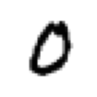

In [10]:
# this should be a zero
show_image(train_x[0], cmap='gray');

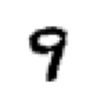

In [11]:
# this should be a nine
show_image(valid_x[-1], cmap='gray');

### Adding and Subtracting Varying Levels of Noise

I'll start by showing an example of Gaussian (Normal) noise.

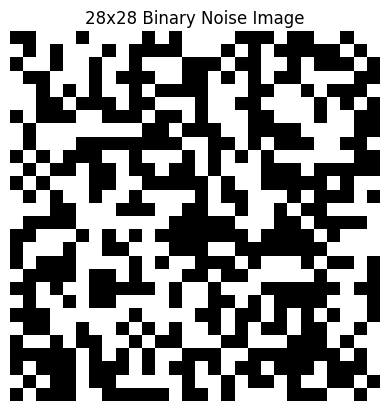

In [73]:
noise_threshold = 0.5

# Generate a binary noise image (1 for white, 0 for black)
noise = (torch.rand(28, 28) >= noise_threshold).float()

plt.imshow(noise, cmap='gray')
plt.title("28x28 Binary Noise Image")
plt.axis('off') 
plt.show()

Next I'll add some noise to a handwritten digit and print out the "probability" (`1 - noise_threshold`) that it's a digit:

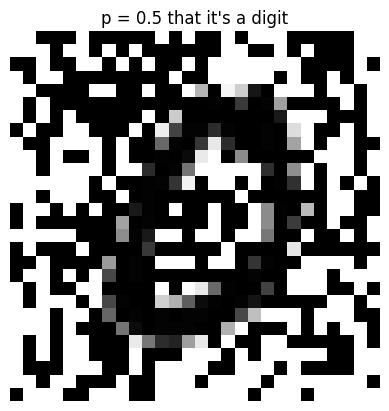

In [133]:
noise_threshold = 0.5

# Generate a binary noise image (1 for white, 0 for black)
noise = (torch.rand(28, 28) >= noise_threshold).float()

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.min(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {1 - noise_threshold} that it's a digit")
plt.axis('off')
plt.show()

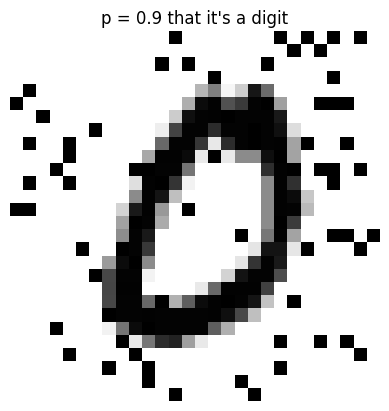

In [134]:
noise_threshold = 0.1

# Generate a binary noise image (1 for white, 0 for black)
noise = (torch.rand(28, 28) >= noise_threshold).float()

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.min(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {1 - noise_threshold} that it's a digit")
plt.axis('off')
plt.show()

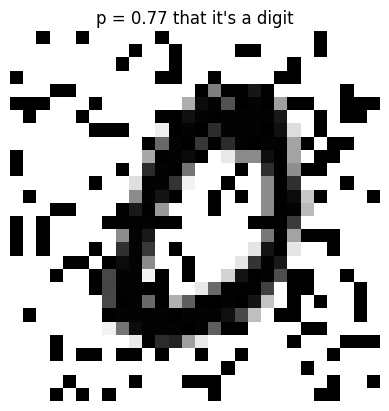

In [237]:
noise_threshold = torch.rand(1).abs()
noise = (torch.rand(28, 28) >= noise_threshold).float() 

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.min(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {1 - noise_threshold.item():.2f} that it's a digit")
plt.axis('off')
plt.show()

I'll also generate images where pixels of the digit are taken away.

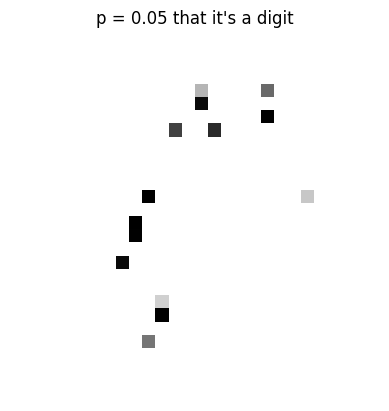

In [242]:
noise_threshold = torch.rand(1).abs()
noise = (torch.rand(28, 28) >= noise_threshold).float() 

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.max(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {noise_threshold.item():.2f} that it's a digit")
plt.axis('off')
plt.show()

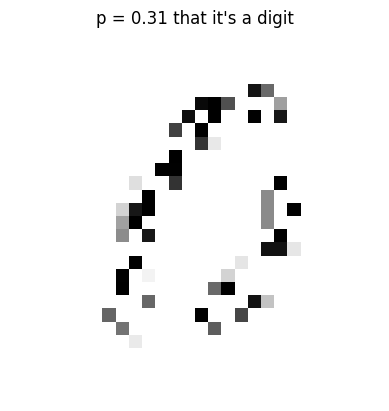

In [251]:
noise_threshold = torch.rand(1).abs()
noise = (torch.rand(28, 28) >= noise_threshold).float() 

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.max(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {noise_threshold.item():.2f} that it's a digit")
plt.axis('off')
plt.show()

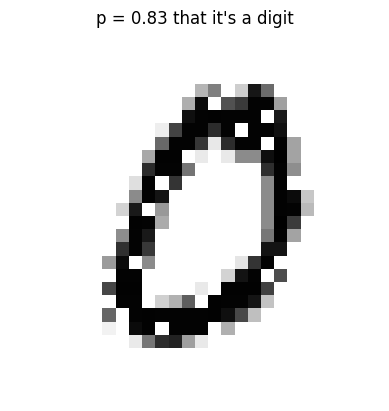

In [259]:
noise_threshold = torch.rand(1).abs()
noise = (torch.rand(28, 28) >= noise_threshold).float() 

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.max(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {noise_threshold.item():.2f} that it's a digit")
plt.axis('off')
plt.show()

I'll create 140,000 different `noise` images. I'll take 70k of those and "add" them to the 60k MNIST training image and 10k validation images and store `1 - noise_threshold` as the target. For the other 70k, I'll "subtract" them from the 60k training digits 10k validation digits and store `noise_threshold` as the target. In total, I'll have 120k training and 20k validation images that I can use to train the full spectrum of noise (additive and subtractive).

In [18]:
noise_imgs = []
noise_thresholds = []

for i in range(140_000):
    noise_threshold = torch.rand(1).abs()
    noise_imgs.append((torch.rand(28, 28) >= noise_threshold).float())
    noise_thresholds.append(noise_threshold)

In [23]:
noise_t = torch.stack(noise_imgs)
thresh_t = tensor(noise_thresholds)

Let's make sure the noise and thresholds look okay:

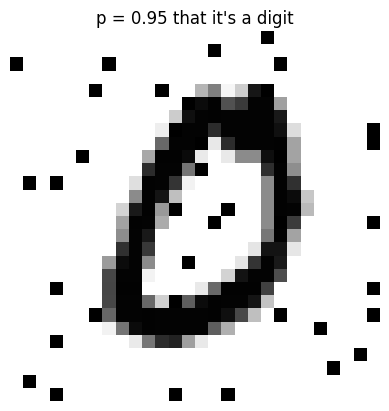

In [24]:
noise = noise_t[0]
thresh = thresh_t[0]

# Combine the inverted digit with noise using element-wise minimum
noisy_image = torch.min(train_x[0], noise)

# Display the result
plt.imshow(noisy_image, cmap='gray')
plt.title(f"p = {1-thresh.item():.2f} that it's a digit")
plt.axis('off')
plt.show()

Now, I'll create my new training and validation sets:

In [25]:
noise_t.shape, train_x.shape, valid_x.shape

(torch.Size([140000, 28, 28]),
 torch.Size([60000, 28, 28]),
 torch.Size([10000, 28, 28]))

In [26]:
noise_train_min = noise_t[:60000]
noise_valid_min = noise_t[60000:70000]

noise_train_max = noise_t[70000:130000]
noise_valid_max = noise_t[130000:]

# additive noise
result_train_min = torch.min(train_x, noise_train_min)
result_valid_min = torch.min(valid_x, noise_valid_min)

# subtractive noise
result_train_max = torch.max(train_x, noise_train_max)
result_valid_max = torch.max(valid_x, noise_valid_max)

# concatenate to create training and validation sets
noise_valid = torch.cat([result_valid_min, result_valid_max])
noise_train = torch.cat([result_train_min, result_train_max])

In [27]:
# additive thresholds
thresh_train_min = 1 - thresh_t[:60000]
thresh_valid_min = 1 - thresh_t[60000:70000]

# subtractive thresholds
thresh_train_max = thresh_t[70000:130000]
thresh_valid_max = thresh_t[130000:]

# concatenate to get training and validation targets
thresh_valid = torch.cat([thresh_valid_min, thresh_valid_max])
thresh_train = torch.cat([thresh_train_min, thresh_train_max])

Finally, I'll spot-check a few training and validation set inputs and targets:

In [10]:
def plot_noise(img, thresh):
    plt.imshow(img, cmap='gray')
    plt.title(f"p = {thresh.item():.2f} that it's a digit")
    plt.axis('off')
    plt.show()

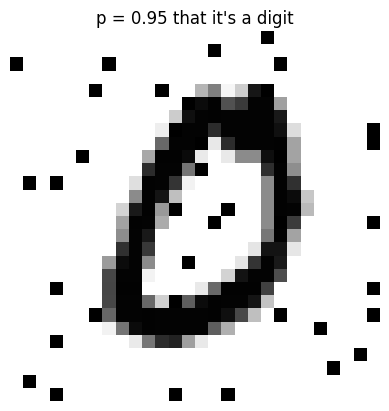

In [29]:
plot_noise(noise_train[0], thresh_train[0])

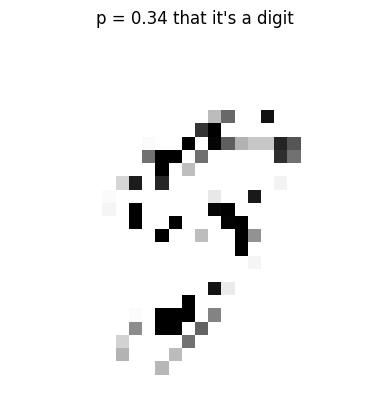

In [30]:
plot_noise(noise_train[-1], thresh_train[-1])

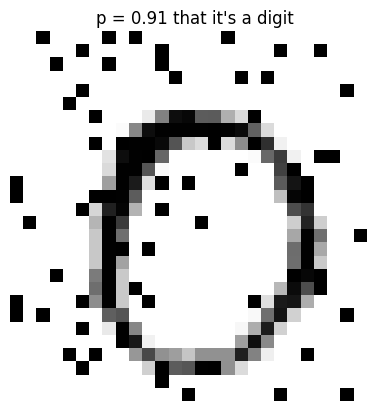

In [33]:
plot_noise(noise_valid[10], thresh_valid[10])

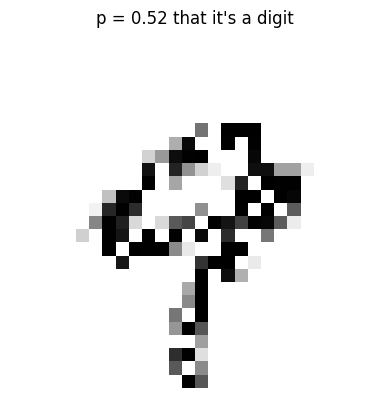

In [34]:
plot_noise(noise_valid[-10], thresh_valid[-10])

## Training an Image Regressor

Now that I have my noisy inputs (and corresponding "probability" targets) I can start training models! I'll start by training a ResNet34 to get a sense of the baseline MSE. I got a major assist from both Claude and ChatGPT to build the appropriate `DataBlock` (and getters `get_items`, `get_x` and `get_y`) based on how my data is sources (4 NumPy arrays).

In [3]:
path = Path('/kaggle/input/noisy-mnist')
train_noise = np.load(path/'noise_train.npy')
train_thresh = np.load(path/'thresh_train.npy')
valid_noise = np.load(path/'noise_valid.npy')
valid_thresh = np.load(path/'thresh_valid.npy')

# Combine train and valid data
all_noise = np.concatenate([train_noise, valid_noise])
all_thresh = np.concatenate([train_thresh, valid_thresh])

In [64]:
all_noise = (all_noise * 255).astype(np.uint8)

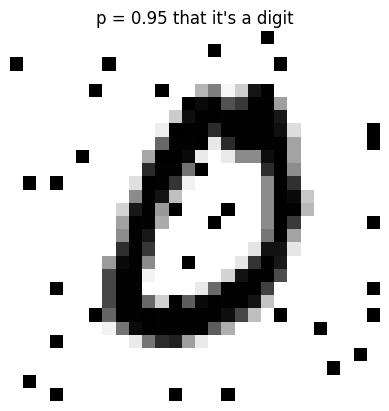

In [65]:
plot_noise(all_noise[0], all_thresh[0])

In [122]:
def get_x(i):
    # Convert NumPy array to a single-channel PIL image with inverted colors
    return PILImageBW.create(all_noise[i])

def get_y(i):
    return all_thresh[i].astype(np.float32)

def get_items(_):
    return range(len(all_noise))

In [123]:
# Create valid_idx for IndexSplitter
valid_idx = list(range(len(train_noise), len(all_noise)))
len(valid_idx)

20000

In [124]:
dblock = DataBlock(
    blocks=(ImageBlock(PILImageBW), RegressionBlock),
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    splitter=IndexSplitter(valid_idx),
    batch_tfms=None
)

In [125]:
dls = dblock.dataloaders(all_noise, bs=1024)

In [126]:
dblock.summary(all_noise)

Setting-up type transforms pipelines
  [255 255 255 ... 255 255 255]
  [  0 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255   0 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[  0   0 255 ...   0   0   0]
  [255   0 255 ... 255   0   0]
  [255   0   0 ... 255   0 255]
  ...
  [255   0   0 ...   0   0   0]
  [255   0   0 ... 255   0   0]
  [  0   0   0 ...   0   0 255]]

 [[  0   0   0 ...   0   0   0]
  [255   0 255 ... 255   0   0]
  [  0   0 255 ...   0   0   0]
  ...
  [  0   0 255 ... 255   0   0]
  [  0   0   0 ...   0   0   0]
  [  0   0   0 ... 255   0   0]]

 ...

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 

I'm not sure why `dls.show_batch` is showing white digits on black backgrounds but I'm guessing it has to do with the colormap it's using.

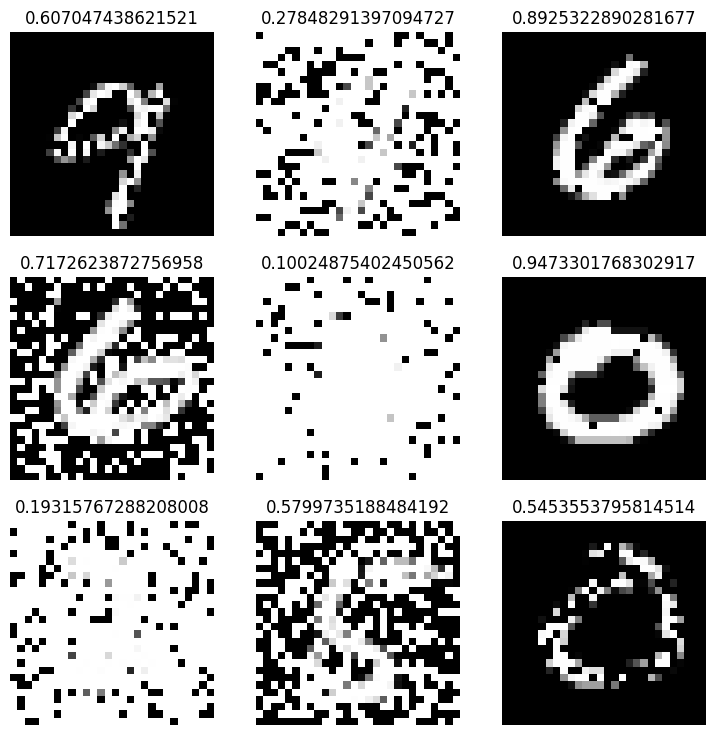

In [128]:
dls.show_batch()

When I plot one of the batch items using `plt.imshow` with `cmap='gray'` I get the expected displayed result:

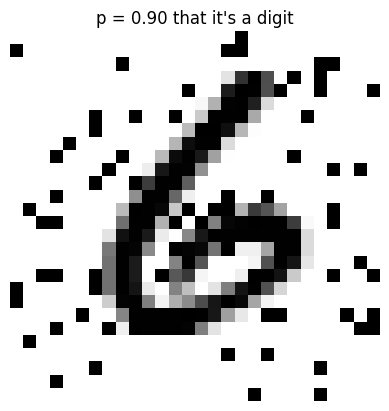

In [133]:
xb, yb = dls.one_batch()
plot_noise(xb[0][0].cpu(), yb[0])

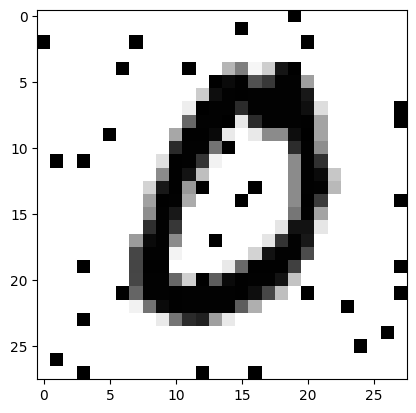

In [136]:
plt.imshow(all_noise[0], cmap='gray');

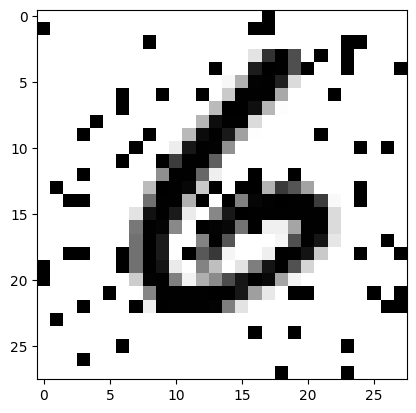

In [138]:
plt.imshow(xb[0][0].cpu(), cmap='gray');

Great! Now onto training:

In [139]:
learn = vision_learner(dls, resnet34, loss_func=mse, metrics=mse, n_in=1, n_out=1)
learn.fine_tune(1, 0.01)

epoch,train_loss,valid_loss,mse,time
0,0.395260,0.016736,0.016736,01:08


epoch,train_loss,valid_loss,mse,time
0,0.018071,0.007796,0.007796,01:17


Given that the predictions are between `0.0` and `1.0`, the mean squared error of `0.008` is not bad! I'll train for a few more epochs:

In [140]:
learn = vision_learner(dls, resnet34, loss_func=mse, metrics=mse, n_in=1, n_out=1)
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,mse,time
0,0.451190,0.015501,0.015501,01:09


epoch,train_loss,valid_loss,mse,time
0,0.018069,0.010948,0.010948,01:16
1,0.011859,0.005137,0.005137,01:17
2,0.007378,0.003288,0.003288,01:17
3,0.005160,0.002453,0.002453,01:17
4,0.004174,0.001957,0.001957,01:17


In [143]:
learn.export('model.pkl')

## Inference

Glancing at the predictions on the validation set, the model is quite good at predicting the "probability" that an image is a handwritten digit!

In [144]:
preds, targs = learn.get_preds(dl=dls.valid)

In [145]:
preds[:10], targs[:10]

(tensor([[0.3102],
         [0.3155],
         [0.3329],
         [0.8646],
         [0.1457],
         [0.9295],
         [0.5802],
         [0.0132],
         [0.3224],
         [0.7590]]),
 tensor([0.3085, 0.2647, 0.3427, 0.8443, 0.1768, 0.9317, 0.5976, 0.0090, 0.3992,
         0.7359]))

I'll make sure that I can get predictions on a single image tensor. The first time I trained a model, I got an error in `learn.predict` that the model expected 3 channels. This prompted me to set `n_in=1` when defining the `vision_learner`.

In [146]:
print(f"{learn.predict(all_noise[0])[0][0]:.2f}")

0.94


Next, I'll test out the model on images it hasn't seen before.

In [119]:
def get_image_array(url):
    # Download the image
    response = requests.get(url)

    # Convert the content to an image
    image = Image.open(BytesIO(response.content))

    image = image.convert("L")

    # Resize the image to 28x28
    image = image.resize((28, 28))

    # Convert the image to a numpy array
    image_array = np.array(image)

    # Normalize the pixel values to [0, 1] and convert to a PyTorch tensor
    #image_tensor = torch.tensor(image_array, dtype=torch.float32) / 255.0
    
    return image_array

In [120]:
def predict_image(url):
    image_array = get_image_array(url)
    print(f"Probability it's a digit: {learn.predict(image_array)[0][0]:.2f}")
    plt.imshow(image_array, cmap='gray');

The model correctly predicts a very high probability that this is an image of a digit (97%):

Probability it's a digit: 0.97


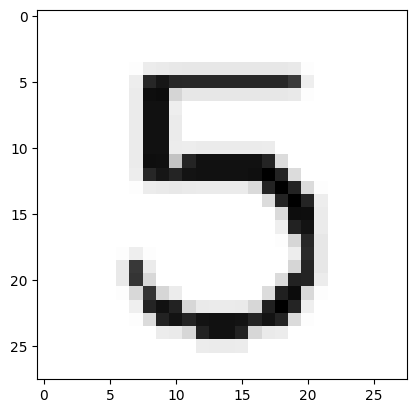

In [149]:
url = 'https://drive.google.com/uc?export=view&id=1qNNgt4z-PPn8JKlQU5pFiRE1KCFnqb2R'
predict_image(url)

Next I'll use the model to predict the handwritten digit probability for an image that is clearly NOT a digit. The model correctly predicts a low probability:

Probability it's a digit: 0.08


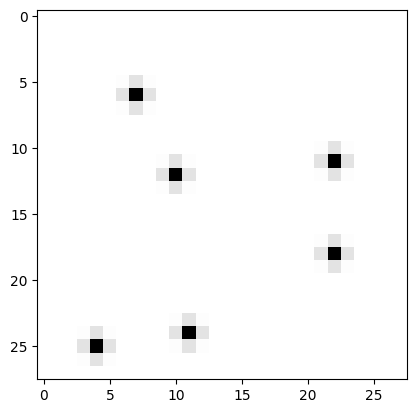

In [150]:
url = 'https://drive.google.com/uc?export=view&id=1LjJEMldL2CaWpYxRqv0Byrg0GqdOWGOO'
predict_image(url)

For another obviously not a digit, the model correctly predicts a very low probability:

Probability it's a digit: 0.05


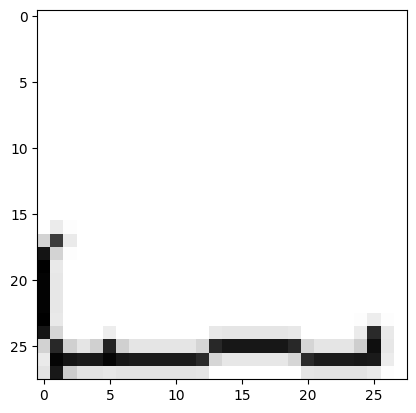

In [151]:
url = 'https://drive.google.com/uc?export=view&id=1OZjXvk74Lpv7teWJ4BY5-xGsjGhblpux'
predict_image(url)

I'll try more difficult images, starting with an easy image of `4`, and then three subsequent images with increasing amounts of noise. The model correctly predicts lower probabilities as more noise is introduced.

Probability it's a digit: 0.98


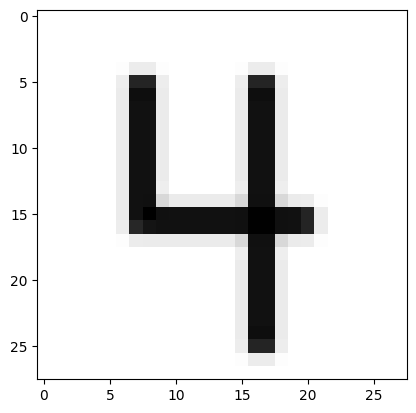

In [152]:
url = 'https://drive.google.com/uc?export=view&id=16rs0ARMoaUqUPmQIrMaVqtMiQvIIhT7n'
predict_image(url)

Probability it's a digit: 0.96


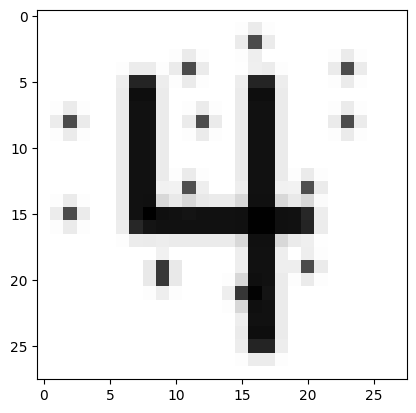

In [153]:
url = 'https://drive.google.com/uc?export=view&id=1UrUZRJpA2hLtTukQNQJdK8VDnL7Ap2xr'
predict_image(url)

Probability it's a digit: 0.94


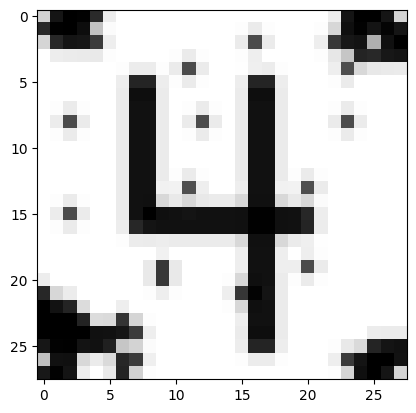

In [154]:
url = 'https://drive.google.com/uc?export=view&id=1di1Pw6yaQlzi-JWOv2JGMuc69UKzlKYm'
predict_image(url)

Probability it's a digit: 0.76


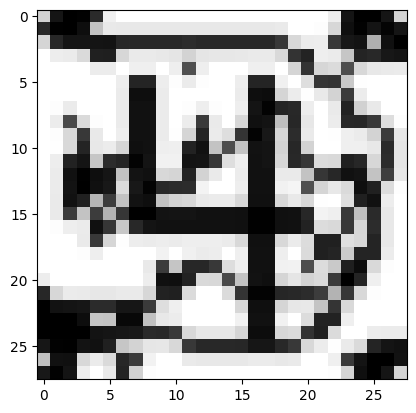

In [155]:
url = 'https://drive.google.com/uc?export=view&id=1opKjl3xJavdINgr7RhiP27JIUbFNto-h'
predict_image(url)

The model is not perfect---it predicts the following blob with a probability of 85%. I would expect something lower. However, it's indicative of the type of data it's seen during training so something I can adjust in the training data.

Probability it's a digit: 0.85


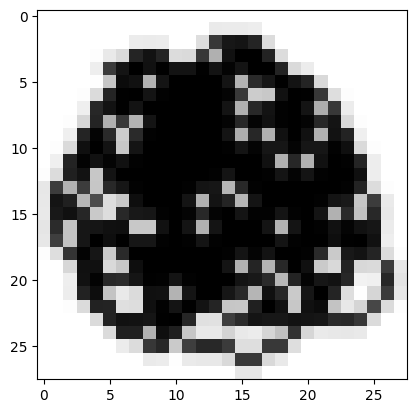

In [157]:
url = 'https://drive.google.com/uc?export=view&id=1JF6dTa38GIlO8FcVGoVQ69Pi0esZe3M1'
predict_image(url)

The model seems more sensitive to black pixels in the corners and sides---the probability that it's a digit drops:

Probability it's a digit: 0.72


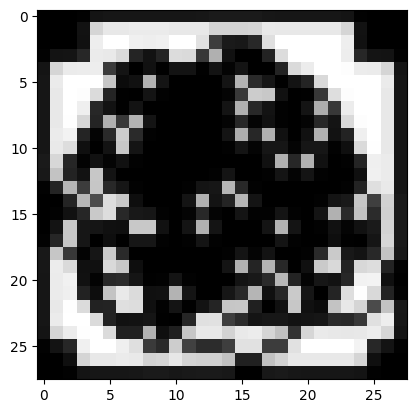

In [158]:
url = 'https://drive.google.com/uc?export=view&id=1dft9riZGAL0aCxGO6LmuvNPP5RSGLrny'
predict_image(url)

I think this model is good enough for now. I'll export it and utilize in [this Huggingface Space](https://huggingface.co/spaces/vishalbakshi/isitadigit).

## Production Environment Results

Here are some examples of how this models fares in the [HuggingFace Space](https://huggingface.co/spaces/vishalbakshi/isitadigit) "production" environment:

Enough randomly placed pixels leads the model to believe a handwritten digit is present. I sort of understand how it comes to this conclusion (based on the training data) and it's not ideal. I would want this image to have a much lower probability.

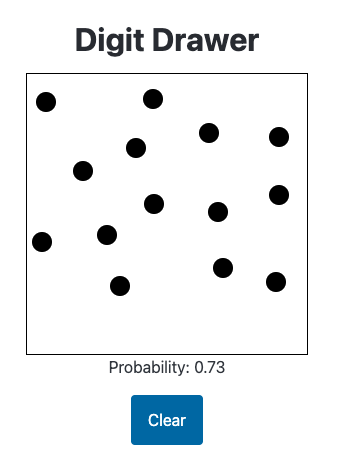

It correctly gives the following images high (90%+) probability of being a handwritten digit (it particularly likes 6s):

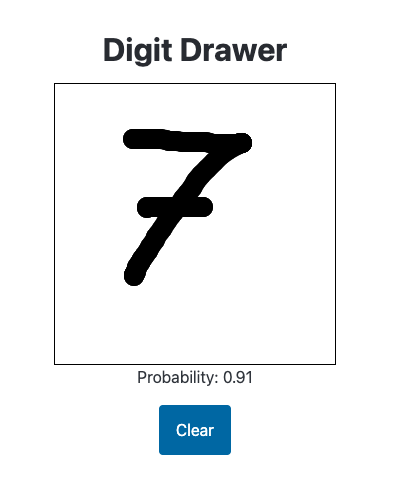

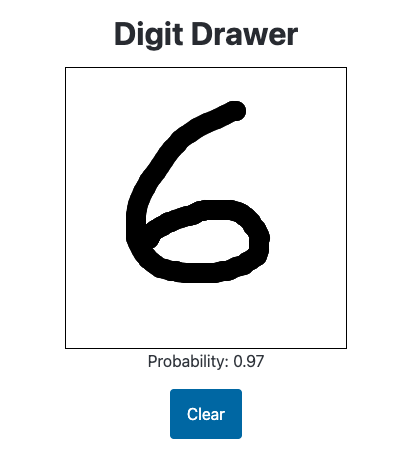

While I appreciate the model giving this `8` a high probability of being a handwritten digit, I need to clamp the predictions to between `0` and `1`:

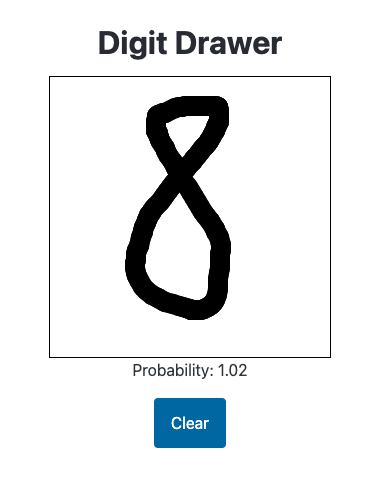

The model incorrectly gives the following image a high probability:

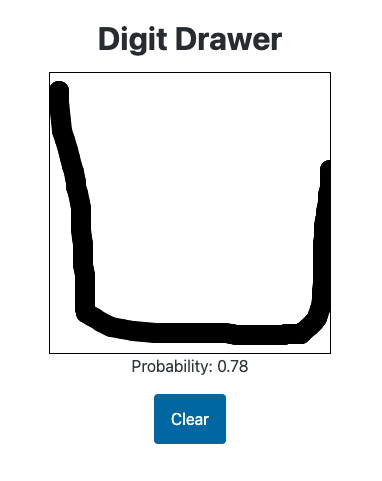

The model correctly gives the following image a relatively low probability:

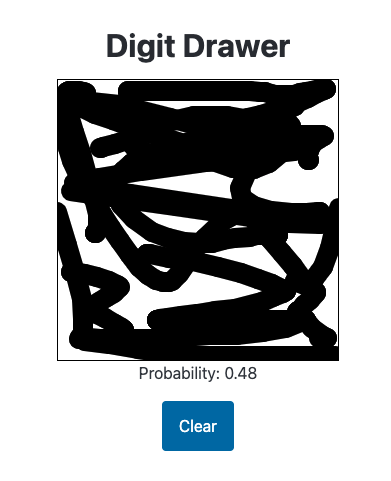

## Training on a Different Dataset

I want to try a different approach: what I train the model only on the data where pixels are "subtracted" from the digit?

In [8]:
train_noise.shape, valid_noise.shape

((120000, 28, 28), (20000, 28, 28))

The second half of each array (training and validation noise) are the "subtracted noise" images:

In [9]:
train_x = train_noise[60000:]
valid_x = valid_noise[10000:]
train_y = train_thresh[60000:]
valid_y = valid_thresh[10000:]

train_x.shape, train_y.shape, valid_x.shape, valid_y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

I'll spot-check a few images of the training and validation sets to make sure it contains only the "subtractive noise" data:

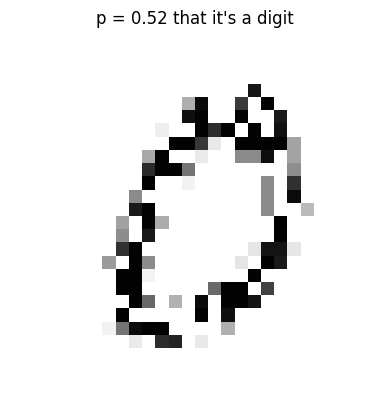

In [11]:
plot_noise(train_x[0], train_y[0])

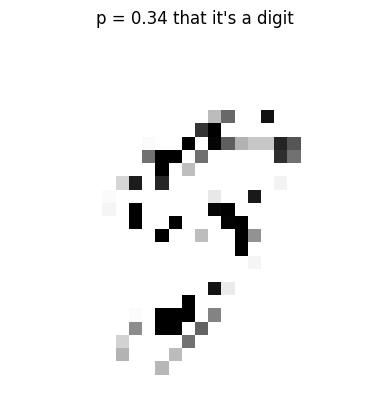

In [12]:
plot_noise(train_x[-1], train_y[-1])

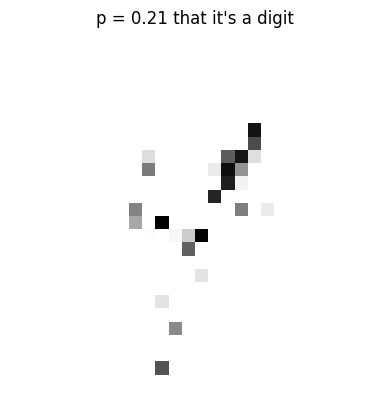

In [13]:
plot_noise(train_x[30000], train_y[30000])

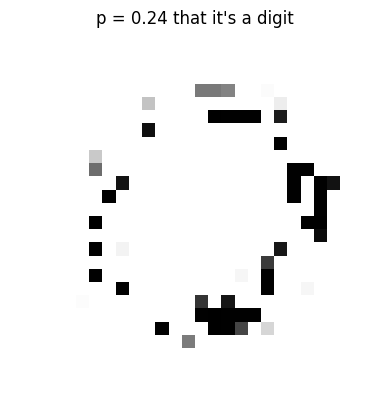

In [14]:
plot_noise(valid_x[0], valid_y[0])

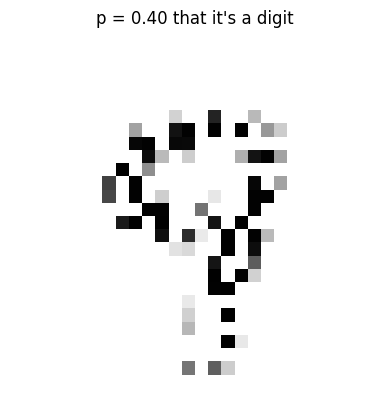

In [15]:
plot_noise(valid_x[-1], valid_y[-1])

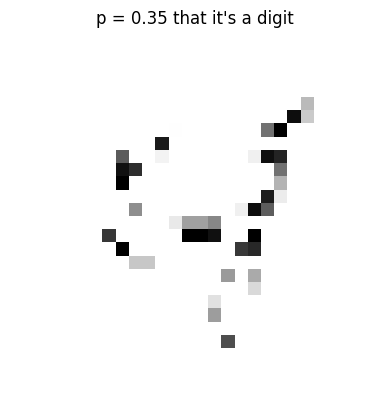

In [16]:
plot_noise(valid_x[5000], valid_y[5000])

Next, I want to "penalize" noisy images that have a low probability (say <=75%) and "favor" images with a high probability (>=75%). I'll create a `transform_threshold` function to achieve this. I prompted Claude to give me such a function and then modified the parameters to get the following result.

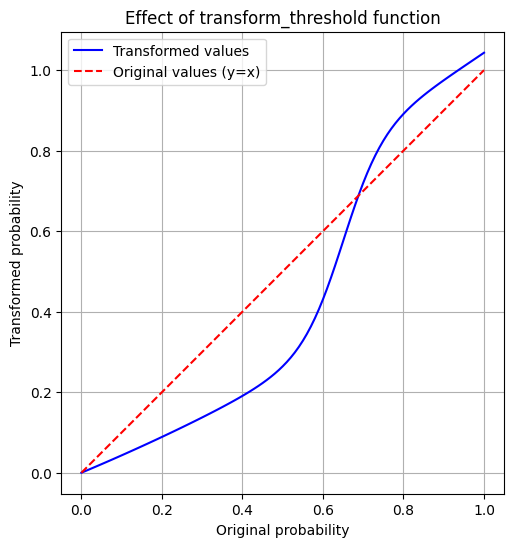

In [80]:
def transform_threshold(p):
    p = tensor(p)
    k1, k2 = 0.5, 20 # Steepness parameters
    mid1, mid2 = 0.65, 0.65  # Midpoints
    lower = torch.sigmoid(k1 * (p - mid1))
    upper = 0.5 * torch.sigmoid(k2 * (p - mid2))
    
    return p * lower + upper

# Create an array of 101 evenly spaced values from 0 to 1
x = torch.linspace(0, 1, 101)

# Apply the transform_threshold function to each value
y = transform_threshold(x)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b-', label='Transformed values')
plt.plot(x, x, 'r--', label='Original values (y=x)')

plt.xlabel('Original probability')
plt.ylabel('Transformed probability')
plt.title('Effect of transform_threshold function')
plt.legend()
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

I'll apply this transformation to the training and validation set target probabilities:

In [81]:
t_train_y = transform_threshold(train_y)
t_valid_y = transform_threshold(valid_y)

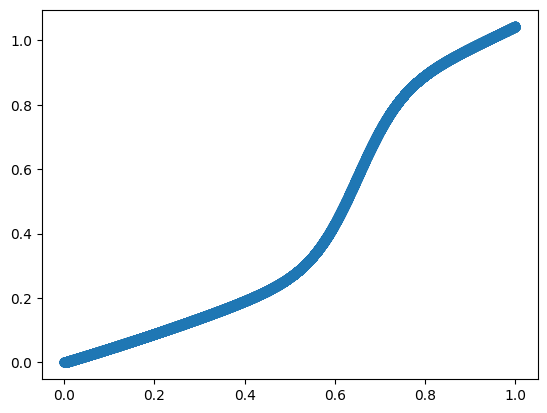

In [85]:
plt.scatter(train_y, t_train_y);

In [82]:
train_y[0], t_train_y[0]

(0.52439004, tensor(0.2915))

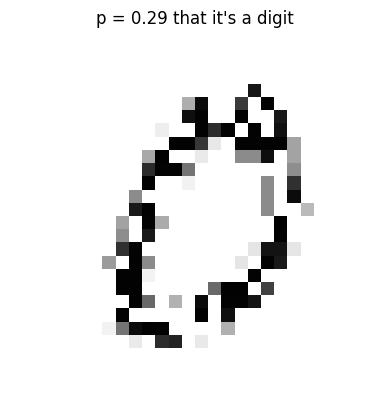

In [83]:
plot_noise(train_x[0], t_train_y[0])

In [93]:
train_y[-1], t_train_y[-1]

(0.3380698, tensor(0.1569))

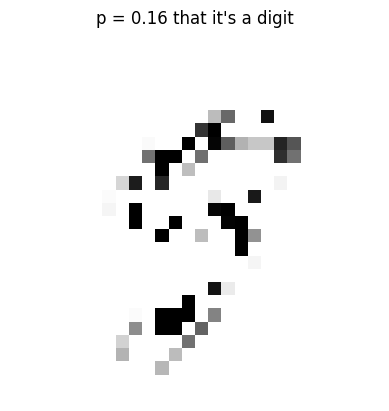

In [87]:
plot_noise(train_x[-1], t_train_y[-1])

In [94]:
train_y[10000], t_train_y[10000]

(0.83755004, tensor(0.9269))

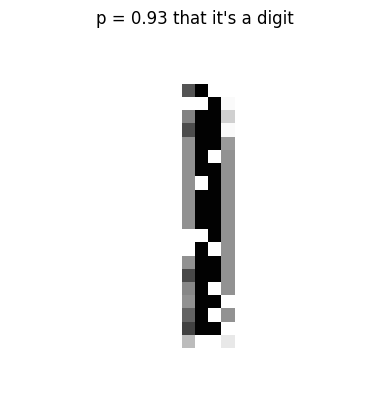

In [88]:
plot_noise(train_x[10000], t_train_y[10000])

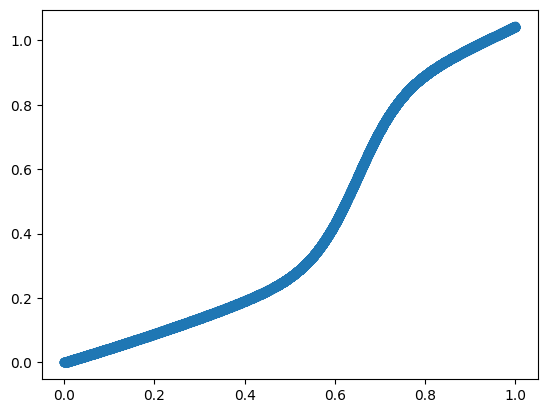

In [86]:
plt.scatter(valid_y, t_valid_y);

In [95]:
valid_y[0], t_valid_y[0]

(0.23614848, tensor(0.1060))

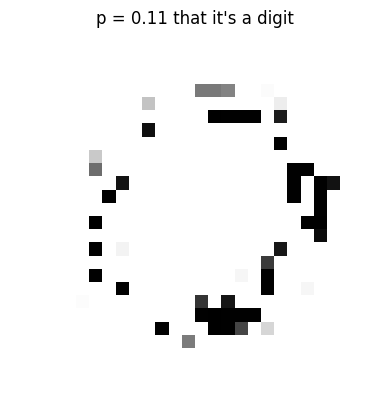

In [89]:
plot_noise(valid_x[0], t_valid_y[0])

In [96]:
valid_y[-1], t_valid_y[-1]

(0.4010573, tensor(0.1915))

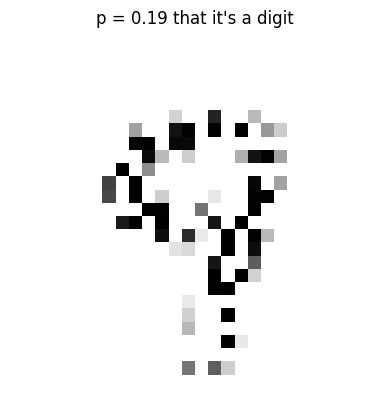

In [90]:
plot_noise(valid_x[-1], t_valid_y[-1])

In [97]:
valid_y[5000], t_valid_y[5000]

(0.34754837, tensor(0.1618))

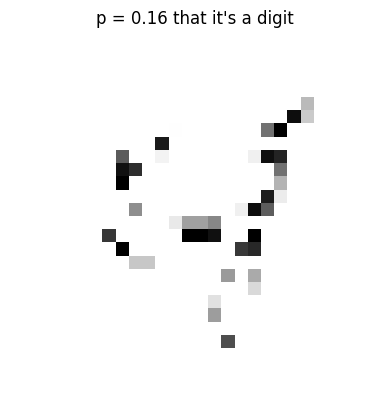

In [92]:
plot_noise(valid_x[5000], t_valid_y[5000])

Great! I have successfully penalized low-probability images. I would expect the model to favor more fully-formed digits, creating what I think is a better user experience for this app.

## Training the New Model

I'll reuse nearly all of the code from before.

In [131]:
# Combine train and valid data
all_noise = np.concatenate([train_x, valid_x])
all_thresh = np.concatenate([t_train_y, t_valid_y])

In [132]:
all_noise = (all_noise * 255).astype(np.uint8)

In [133]:
train_x.shape, valid_x.shape, all_noise.shape, t_train_y.shape, t_valid_y.shape, all_thresh.shape

((60000, 28, 28),
 (10000, 28, 28),
 (70000, 28, 28),
 torch.Size([60000]),
 torch.Size([10000]),
 (70000,))

In [134]:
def get_x(i):
    # Convert NumPy array to a single-channel PIL image with inverted colors
    return PILImageBW.create(all_noise[i])

def get_y(i):
    return all_thresh[i].astype(np.float32)

def get_items(_):
    return range(len(all_noise))

In [135]:
# Create valid_idx for IndexSplitter
valid_idx = list(range(len(train_x), len(all_noise)))
len(valid_idx)

10000

In [136]:
dblock = DataBlock(
    blocks=(ImageBlock(PILImageBW), RegressionBlock),
    get_items=get_items,
    get_x=get_x,
    get_y=get_y,
    splitter=IndexSplitter(valid_idx),
    batch_tfms=None
)

In [137]:
dblock.summary(all_noise)

Setting-up type transforms pipelines
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 ...

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]]

 [[255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  ...
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 255 255]
  [255 255 255 ... 255 

In [138]:
dls = dblock.dataloaders(all_noise, bs=1024)

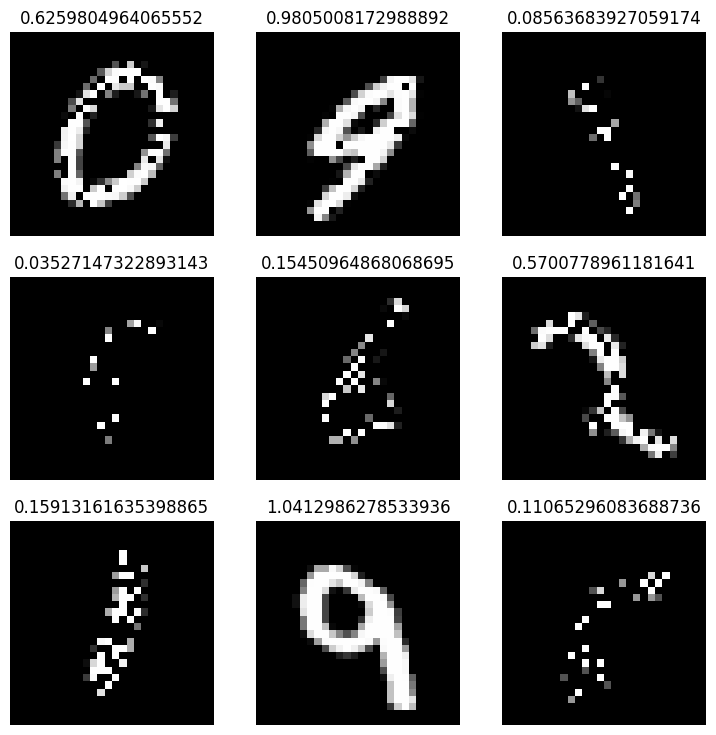

In [139]:
dls.show_batch()

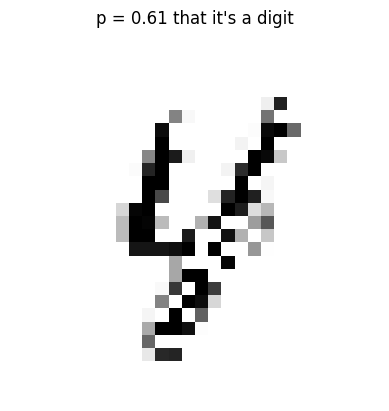

In [140]:
xb, yb = dls.one_batch()
plot_noise(xb[0][0].cpu(), yb[0])

The MSE for this dataset (`0.008`) is 4x than the first dataset (`0.002`).

In [141]:
learn = vision_learner(dls, resnet34, loss_func=mse, metrics=mse, n_in=1, n_out=1)
learn.fine_tune(5, 0.01)

epoch,train_loss,valid_loss,mse,time
0,1.144769,0.068298,0.068298,00:32


epoch,train_loss,valid_loss,mse,time
0,0.052315,0.035616,0.035616,00:36
1,0.038064,0.013611,0.013611,00:37
2,0.032048,0.015357,0.015357,00:38
3,0.026942,0.013210,0.013210,00:39
4,0.018786,0.008574,0.008574,00:39


In [142]:
learn.export('model2.pkl')

## Inference

I'll take a look at the predictions and a few test images before deploying this model in my HuggingFace Space. At first glance, the model looks pretty good at predicting the validation set:

In [121]:
preds, targs = learn.get_preds(dl=dls.valid)
preds[:10], targs[:10]

(tensor([[0.1268],
         [0.8752],
         [0.0170],
         [0.9900],
         [0.2933],
         [0.0500],
         [0.9181],
         [0.9602],
         [1.0142],
         [0.8437]]),
 tensor([0.1060, 0.8329, 0.0078, 0.9869, 0.2650, 0.0298, 0.9310, 0.9779, 1.0219,
         0.9140]))

I'll make sure that `learn.predict` works as expected in my "production" environment:

In [122]:
print(f"{learn.predict(x[0])[0][0]:.2f}")

0.31


This model predicts very high (higher than the first model) probabilities for images that are meant to be handwritten digits:

Probability it's a digit: 0.99


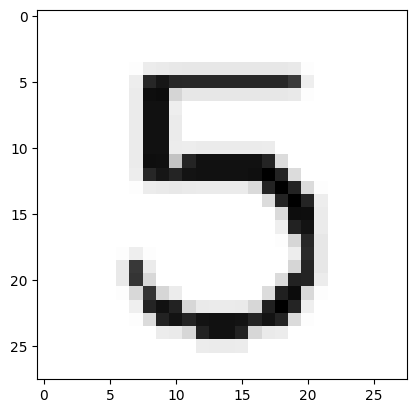

In [123]:
url = 'https://drive.google.com/uc?export=view&id=1qNNgt4z-PPn8JKlQU5pFiRE1KCFnqb2R'
predict_image(url)

Probability it's a digit: 1.00


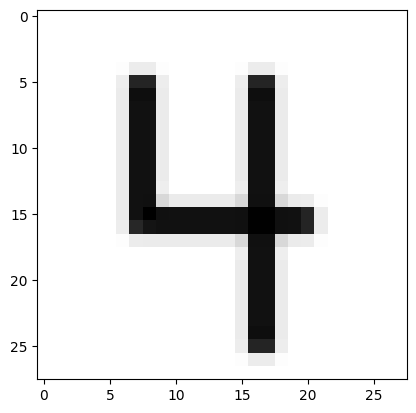

In [125]:
url = 'https://drive.google.com/uc?export=view&id=16rs0ARMoaUqUPmQIrMaVqtMiQvIIhT7n'
predict_image(url)

This model also seems to be better at predicting low probability for obvious not-digits:

Probability it's a digit: 0.04


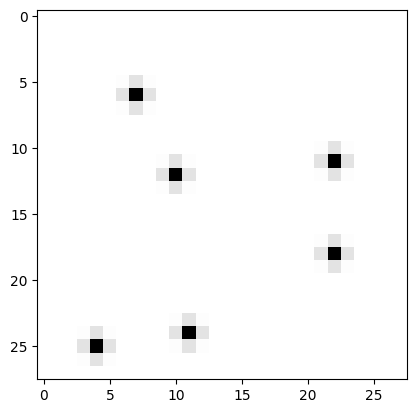

In [126]:
url = 'https://drive.google.com/uc?export=view&id=1LjJEMldL2CaWpYxRqv0Byrg0GqdOWGOO'
predict_image(url)

Probability it's a digit: 0.10


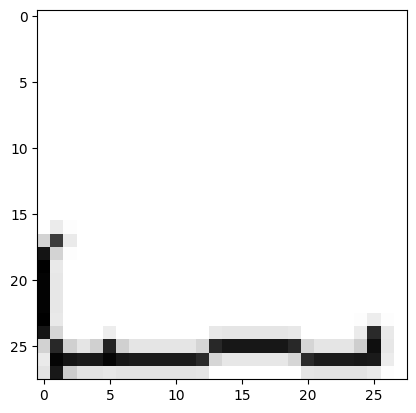

In [124]:
url = 'https://drive.google.com/uc?export=view&id=1OZjXvk74Lpv7teWJ4BY5-xGsjGhblpux'
predict_image(url)

## Production Environment Results

This model is better at predicting a low probability for random noise:

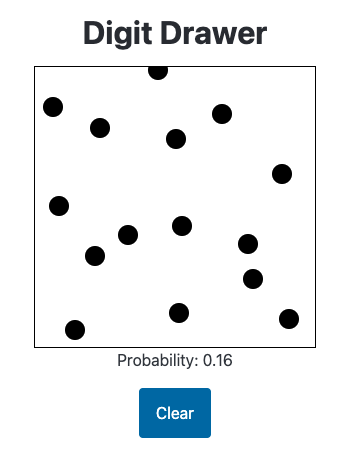

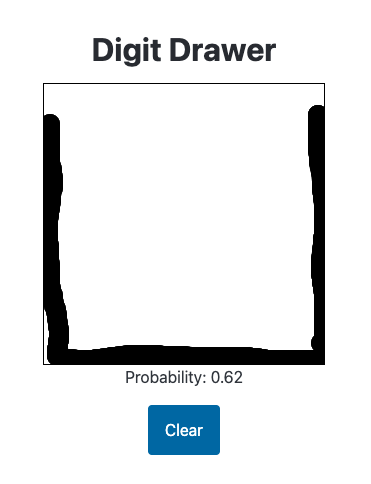

It performs worse when the image is full of black pixels.

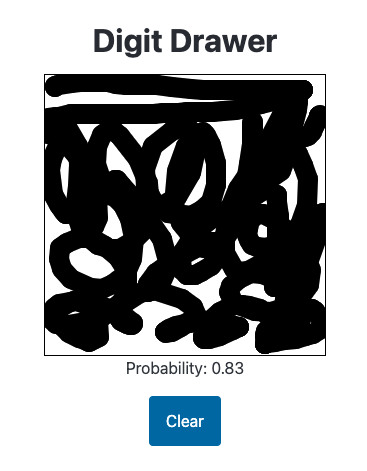

It predicts obviously-digits with higher probability than before:

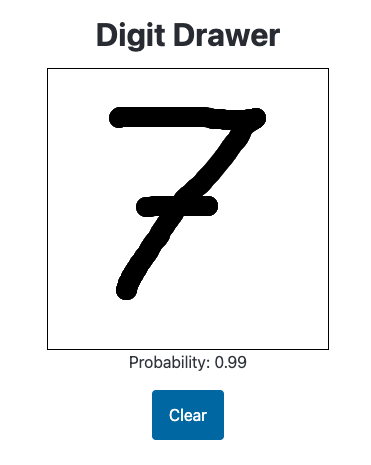

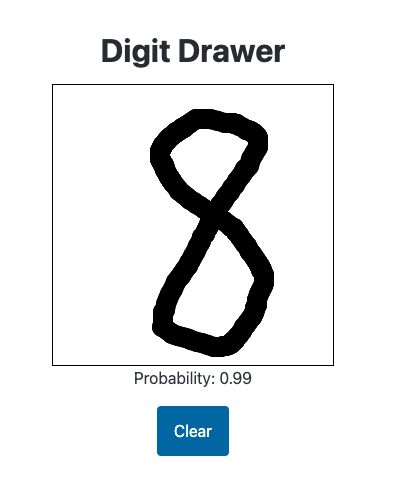

Though it predicts some digits with higher than `1.00`---I'll implement a clamp on the probability to resolve this issue:

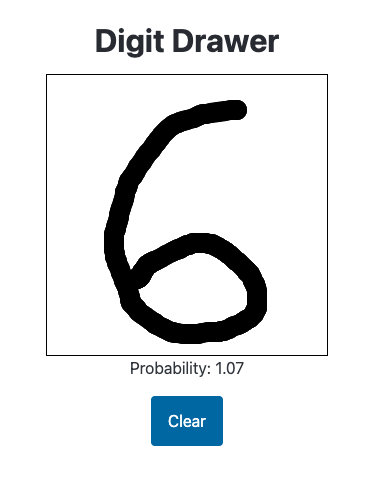

## Final Thoughts

This exercise turned out to be even more exciting than I expected (and I was already pretty pumped!). Here’s what I learned:

- **Production feedback is unmatched.** The best move was deploying the initial model quickly with a user interface to see how it performed in real-world conditions. That feedback led me to revamp the training dataset with adjustments I wouldn’t have thought of otherwise, resulting in a better user experience.

- **Building a good “product” is tougher than I thought.** I assumed generating synthetic data, training a model, and deploying it with MNIST would be straightforward. _I was wrong!_ I’ve put in 5-10 hours (including time wrestling with deployment dependencies) and still wouldn’t say the model is perfect for users.

- **Claude accelerates the learning curve.** A few simple prompts were all it took for Claude to generate a [working prototype](https://codepen.io/vishalbakshi/full/eYweKrN). Claude handled 95% of the frontend code. Without it, I’d have spent days figuring out how to create a responsive UI with a drawable canvas and real-time prediction display—and might’ve abandoned the project entirely without that assist.

I hope you enjoyed this notebook! If so, please give it an upvote :).